<a href="https://colab.research.google.com/github/Mohammed-Fayaz-Ahamed/Air-Quality-forcasting/blob/main/Air_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <font color='#e74c3c'> <i> Project Requrements </i> </font>

<h2>P-385 Air Quality forecasting(CO2 emissions) </h2>

<h3>Business Objective:</h3>
To forecast Co2 levels for an organization so that the organization can follow government norms with respect to Co2 emission levels.

<h3>Data Set Details:</h3>
Time parameter and levels of Co2 emission

<h3>Acceptance criteria:</h3>
<ol>
    <li>
        Detailed EDA (Visualization, missing value handling, outlier detection, skewness removal etc.)
    </li>
    <li>Find the variables which are co related and consider building in your model and other feature engineering stuff if you can.</li>
    <li>Pay attention to splitting of data.</li>
    <li>Use your own understanding for identifying the algorithms that you need to use. However since it's mostly a forecasting problem use models associated with it.</li>
    <li>Once model is finalized train it using whole data available</li>
    <li>Use plot libraries to output the finding in each state</li>
    <li>You can use Jupyter or any other notebook for the same or develop with desktop IDEs like Visual Studio</li>
    <li>The project should be in working condition which is the most important thing even if we don’t use all the considerations as described above. Deploy it using any technique suitable.</li>
</ol>

### Library imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox, chi2

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import ProbPlot

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings(action='ignore')

## <font color='#e74c3c'> Read data </font>

In [ ]:
df = pd.read_csv('emission_data_processed.csv')
df.columns = ['Year', 'Emission_MT']
df.head()

,Year,Emission_MT
0,1750,18.611874
1,1751,18.814458
2,1752,19.010336
3,1753,19.220980
4,1754,19.467160


## <font color='#e74c3c'> EDA/ Pre-processing </font>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         273 non-null    int64  
 1   Emission_MT  273 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.4 KB


### <font color='#1abc9c'> Truncate the dataset to start from 1800. Data before that is very sparse. </font>

In [ ]:
df_filtered = df[(df['Year'] >= 1800) & (df['Year'] <= 2022)].reset_index(drop=True)
df_filtered.head()

,Year,Emission_MT
0,1800,65.596704
1,1801,63.972100
2,1802,80.620946
3,1803,59.077012
4,1804,63.538354


In [ ]:
# create new df
df = df_filtered.copy()
# converting 'Year' column from int64 to datetime
# df['Year'] = pd.to_datetime(df['Year'], format='%Y')

# delete df_filtered
try:
    del(df_filtered)
except NameError:
    pass

df.head()

,Year,Emission_MT
0,1800,65.596704
1,1801,63.972100
2,1802,80.620946
3,1803,59.077012
4,1804,63.538354


### <font color='#1abc9c'> Set "Year" column as the index </font>

In [ ]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y').dt.year
df.set_index('Year', inplace=True)
# df.index = df.index.astype(int)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 223 entries, 1800 to 2022
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Emission_MT  223 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB
None


,Emission_MT
Year,
1800,65.596704
1801,63.972100
1802,80.620946
1803,59.077012
1804,63.538354


### <font color='#1abc9c'> Check for missing years </font>

In [ ]:
all_years = pd.date_range(start='1900-01-01', end='2022-12-31', freq='A-DEC')
all_years

DatetimeIndex(['1900-12-31', '1901-12-31', '1902-12-31', '1903-12-31',
               '1904-12-31', '1905-12-31', '1906-12-31', '1907-12-31',
               '1908-12-31', '1909-12-31',
               ...
               '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31',
               '2017-12-31', '2018-12-31', '2019-12-31', '2020-12-31',
               '2021-12-31', '2022-12-31'],
              dtype='datetime64[ns]', length=123, freq='A-DEC')

In [ ]:
missing_years = set(all_years.year) - set(df.index)
if missing_years:
    print("Missing years: ", missing_years)
else:
    print("No missing years found.")

No missing years found.


### <font color='#1abc9c'> Check for null values </font>

In [ ]:
df.isna().sum(); df.isnull().sum()

Emission_MT    0
dtype: int64

### <font color='#1abc9c'> Scale values from MT to kMT and apply Min-Max Scaler </font>

In [ ]:
df['Emission_kMT'] = df['Emission_MT']/1000
df.drop('Emission_MT', axis=1, inplace=True)
df.head()

,Emission_kMT
Year,
1800,0.065597
1801,0.063972
1802,0.080621
1803,0.059077
1804,0.063538


In [ ]:
# Normalizing
scaler = MinMaxScaler()
df.Emission_kMT = scaler.fit_transform(df)
df.head()

,Emission_kMT
Year,
1800,0.000088
1801,0.000066
1802,0.000290
1803,0.000000
1804,0.000060


In [ ]:
print(df[(df[['Emission_kMT']] <= 0)['Emission_kMT']])
# Eliminate zero value
zero_threshold = 1e-10
df['Emission_kMT'] = df['Emission_kMT'] + zero_threshold
df.head()

      Emission_kMT
Year              
1803           0.0


,Emission_kMT
Year,
1800,8.781589e-05
1801,6.593358e-05
1802,2.901821e-04
1803,1.000000e-10
1804,6.009132e-05


In [ ]:
df.describe()

,Emission_kMT
count,2.230000e+02
mean,2.133322e-01
std,2.919635e-01
min,1.000000e-10
25%,6.457512e-03
50%,8.118731e-02
75%,3.237877e-01
max,1.000000e+00


### <font color='#1abc9c'> Reduce skewness using Box-Cox transformation </font>

In [ ]:
original_skewness = df['Emission_kMT'].skew()

zero_threshold = 10e-10

# Apply Box-Cox transformation to reduce skewness
transformed_data, optimal_lambda = boxcox(df['Emission_kMT'] + zero_threshold)
df['boxcox'] = transformed_data

transformed_skewness = df['boxcox'].skew()

print("Original Skewness:", original_skewness)
print("Transformed Skewness:", transformed_skewness)

df.head()

Original Skewness: 1.3979210828770952
Transformed Skewness: -0.15048369696429262


,Emission_kMT,boxcox
Year,,
1800,8.781589e-05,-4.903121
1801,6.593358e-05,-4.967906
1802,2.901821e-04,-4.599218
1803,1.000000e-10,-6.126281
1804,6.009132e-05,-4.988264


## <font color='#e74c3c'> Visualization </font>

### <font color='#1abc9c'> Outlier Detection - Statistical Method using IQR </font>

In [ ]:
Q1 = np.percentile(df.Emission_kMT, 25)
Q3 = np.percentile(df.Emission_kMT, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = [x for x in df.Emission_kMT if x < lower_bound or x > upper_bound]
print(outliers)

[0.8236764306455667, 0.8477585735311381, 0.8623635536370757, 0.8475886126299499, 0.8964294652715817, 0.9268738964403903, 0.9403167612842231, 0.9483168255313497, 0.9546130558059851, 0.9545326122990193, 0.9544465554144019, 0.9696786718077511, 0.9896545581261537, 0.9970079868137041, 0.9422670860340195, 0.9909683101073075, 1.0000000001]


### <font color='#1abc9c'> Visualizing Outliers </font>

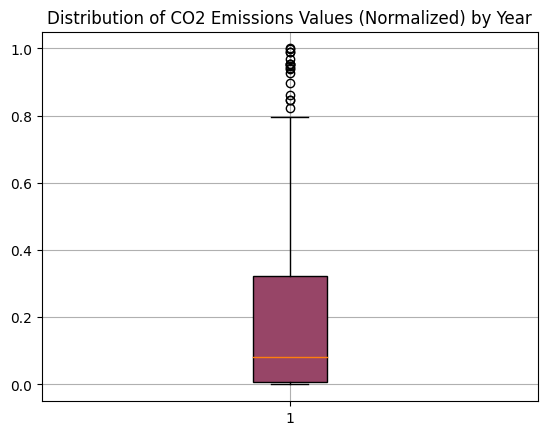

In [ ]:
boxprops = dict(facecolor='#974567', edgecolor='black')
whiskerprops = dict(color='black')

plt.boxplot(df['Emission_kMT'], patch_artist=True, boxprops=boxprops, whiskerprops=whiskerprops)
plt.title('Distribution of CO2 Emissions Values (Normalized) by Year')
plt.grid()
plt.show()

### <font color='#1abc9c'> Outlier Detection - Scatter Plot with Threshold Line </font>

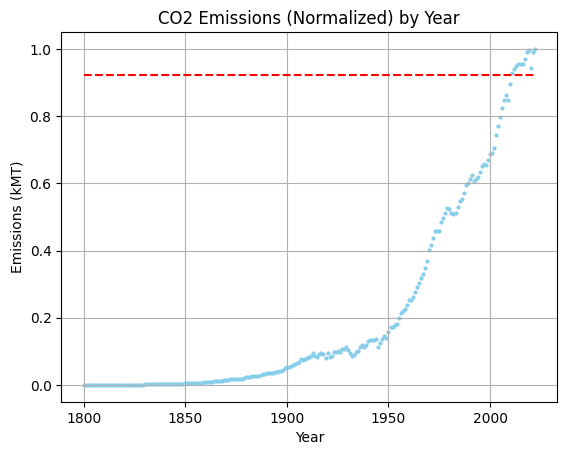

In [ ]:
threshold = df['Emission_kMT'].quantile(0.95)
plt.scatter(df.index, df['Emission_kMT'], s=4, c='skyblue')
plt.plot([df.index.min(), df.index.max()], [threshold, threshold], 'r--')
plt.title('CO2 Emissions (Normalized) by Year')
plt.xlabel('Year')
plt.ylabel('Emissions (kMT)')
plt.grid()
plt.show()

### <font color='#1abc9c'> ACF Plot </font> <a id='acf_plot'></a>

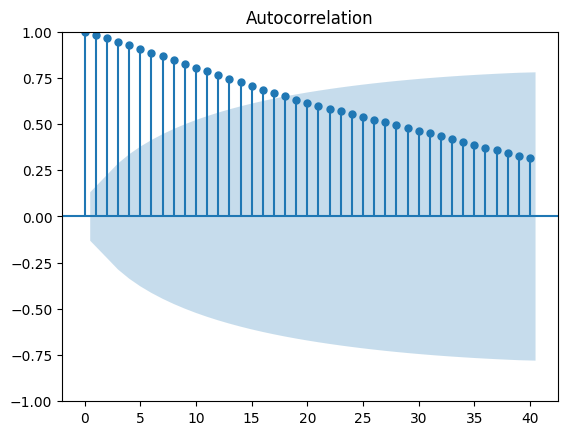

In [ ]:
plot_acf(df.Emission_kMT, lags='40')
plt.show()

### <font color='#1abc9c'> PACF Plot </font> <a id='pacf_plot'></a>

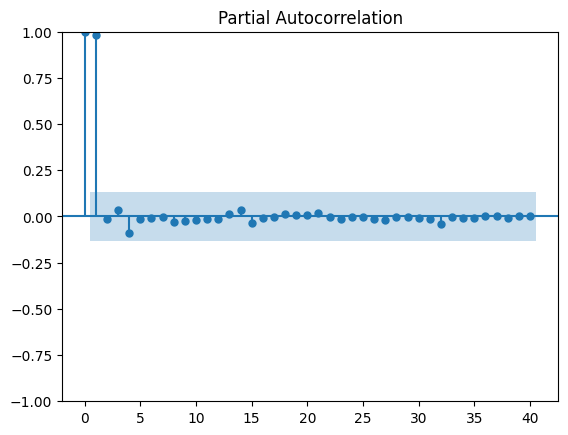

In [ ]:
plot_pacf(df.Emission_kMT, lags='40')
plt.show()

## <font color='#e74c3c'> Data Preparation </font>

In [ ]:
# removing boxcox
df = pd.DataFrame(df['Emission_kMT'], index=df.index)
df.head()

,Emission_kMT
Year,
1800,8.781589e-05
1801,6.593358e-05
1802,2.901821e-04
1803,1.000000e-10
1804,6.009132e-05


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 223 entries, 1800 to 2022
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Emission_kMT  223 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB


### <font color='#1abc9c'> Split into Train and Test Datasets </font>

In [ ]:
training_size = int(df.Emission_kMT.size * 0.8)
training_data = df.iloc[:training_size]
testing_data = df.iloc[training_size:]
training_data.shape, testing_data.shape

((178, 1), (45, 1))

In [ ]:
orig_training_data = training_data.copy()
orig_testing_data = testing_data.copy()

id(orig_training_data), id(training_data), id(orig_testing_data), id(testing_data)

(133294334342192, 133294298239360, 133294334344784, 133294298242864)

### <font color='#1abc9c'> Function to display metrics on forecasted values </font><span style='font-size: 10pt'> (Contributed By: mohammedfayazahamed20@gmail.com) </span> </font>

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = np.mean((forecast - actual)**2)  # MSE
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'mse':mse})

<hr/>

# <font color='#e74c3c'> Modeling </font>

## <font color='#e74c3c'> <u><b>1. Exponential Smoothing</b></u> </font>

### <font color='#1abc9c'> Simple Exponential Smoothing (SES) </font>

In [ ]:
alpha=0.05 # weightage

ses_model_1 = SimpleExpSmoothing(training_data.Emission_kMT)
ses_fitted_model_1 = ses_model_1.fit(smoothing_level=alpha, optimized=True)
ses_fitted_model_1.fittedvalues

Year
1800    0.000088
1801    0.000088
1802    0.000087
1803    0.000097
1804    0.000092
          ...   
1973    0.238597
1974    0.249637
1975    0.260025
1976    0.269951
1977    0.280641
Length: 178, dtype: float64

In [ ]:
training_data['SES'] = ses_fitted_model_1.fittedvalues.shift(-1)
training_data.head()

,Emission_kMT,SES
Year,,
1800,8.781589e-05,0.000088
1801,6.593358e-05,0.000087
1802,2.901821e-04,0.000097
1803,1.000000e-10,0.000092
1804,6.009132e-05,0.000090


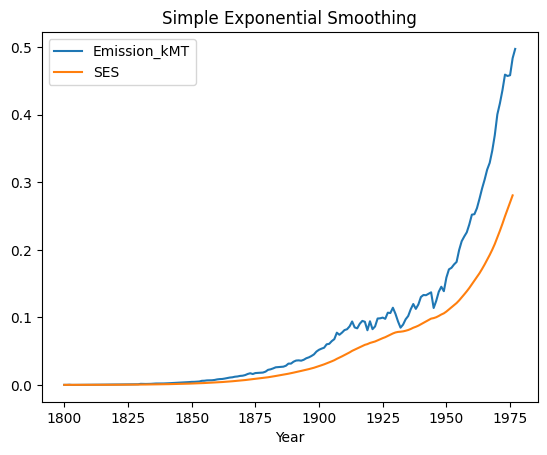

In [ ]:
training_data[['Emission_kMT', 'SES']].plot()
plt.title('Simple Exponential Smoothing')
plt.show()

<div style="padding: 5px; background-color: #eefefe;"> <font color='#121212'> <i> As expected, from the above chart, Simple Exponential Smoothing is not a good fit for the given data and hence is not a good method to model trending and seasonal data. We will explore other methods.  </i> </font> </div>

### <font color='#1abc9c'> Holt's Method (aka Double Exponential Smoothing) (additive) (DESa) </font>

In [ ]:
des_model_a_1 = ExponentialSmoothing(training_data.Emission_kMT, trend='add')
des_fitted_model_a_1 = des_model_a_1.fit()
training_data['DESa'] = des_fitted_model_a_1.fittedvalues.shift(-1)
training_data.head()

,Emission_kMT,SES,DESa
Year,,,
1800,8.781589e-05,0.000088,0.000096
1801,6.593358e-05,0.000087,0.000070
1802,2.901821e-04,0.000097,0.000324
1803,1.000000e-10,0.000092,-0.000009
1804,6.009132e-05,0.000090,0.000059


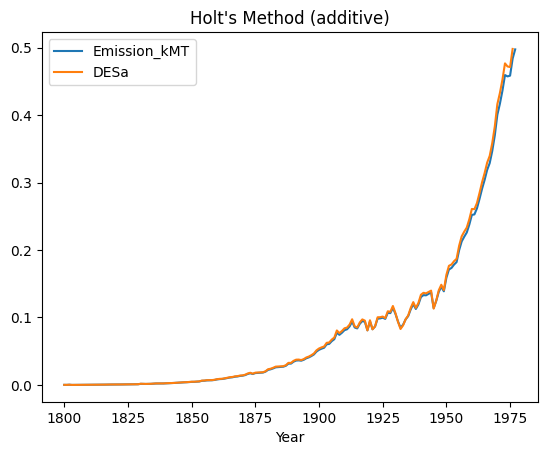

In [ ]:
training_data[['Emission_kMT', 'DESa']].plot()
plt.title('Holt\'s Method (additive)')
plt.show()

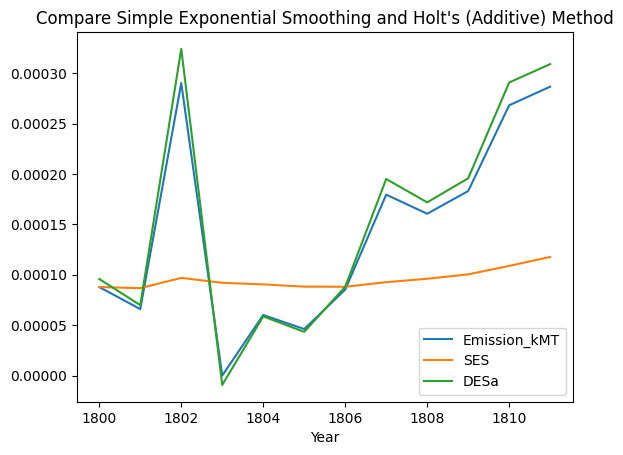

In [ ]:
training_data[['Emission_kMT', 'SES', 'DESa']].iloc[:12].plot()
plt.title('Compare Simple Exponential Smoothing and Holt\'s (Additive) Method')
plt.show()

<div style="padding: 5px; background-color: #eefefe;"> <font color='#121212'> <i> Holt's (additive) Method is a fairly good fit. But we will explore multiplicative method as well as Holt-Winters Method to see if there is any improvement. </i> </font> </div>

### <font color='#1abc9c'> Holt's Method (aka Double Exponential Smoothing) (multiplicative) (DESm) </font>

In [ ]:
des_model_m_1 = ExponentialSmoothing(training_data['Emission_kMT'], trend='mul')
des_fitted_model_m_1 = des_model_m_1.fit()
training_data['DESm'] = des_fitted_model_m_1.fittedvalues.shift(-1)
training_data.head()

,Emission_kMT,SES,DESa,DESm
Year,,,,
1800,8.781589e-05,0.000088,0.000096,0.000105
1801,6.593358e-05,0.000087,0.000070,0.000068
1802,2.901821e-04,0.000097,0.000324,0.000350
1803,1.000000e-10,0.000092,-0.000009,0.000011
1804,6.009132e-05,0.000090,0.000059,0.000087


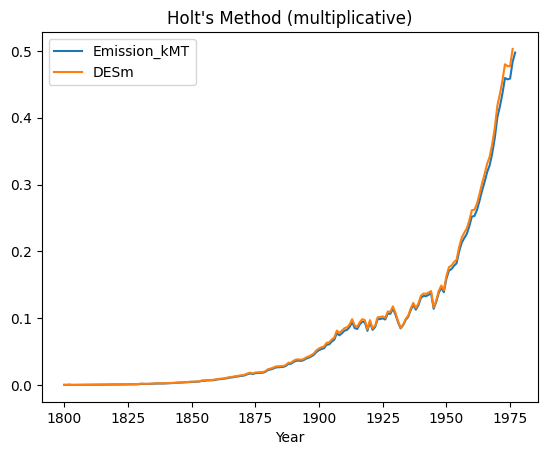

In [ ]:
training_data[['Emission_kMT', 'DESm']].plot()
plt.title('Holt\'s Method (multiplicative)')
plt.show()

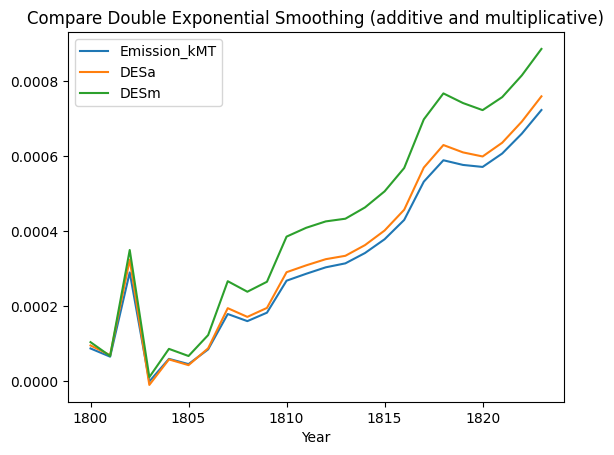

In [ ]:
training_data[['Emission_kMT', 'DESa', 'DESm']].iloc[:24].plot()
plt.title('Compare Double Exponential Smoothing (additive and multiplicative)')
plt.show()

<div style="padding: 5px; background-color: #eefefe;"> <font color='#121212'> <i> Holt's (additive) Method provides a better fit than Holt's (multiplicative) Method We will continue to explore further.  </i> </font> </div>

#### <font color='#1abc9c'> Function to calculate RMSE </font>

In [ ]:
def RMSE(org, pred):
    rmse=np.sqrt(np.mean((np.array(org)-np.array(pred))**2))
    return rmse

In [ ]:
training_data

,Emission_kMT,SES,DESa,DESm
Year,,,,
1800,8.781589e-05,0.000088,0.000096,0.000105
1801,6.593358e-05,0.000087,0.000070,0.000068
1802,2.901821e-04,0.000097,0.000324,0.000350
1803,1.000000e-10,0.000092,-0.000009,0.000011
1804,6.009132e-05,0.000090,0.000059,0.000087
...,...,...,...,...
1973,4.594046e-01,0.249637,0.476713,0.480055
1974,4.574077e-01,0.260025,0.472116,0.477236
1975,4.585351e-01,0.269951,0.471294,0.477032


#### <font color='#1abc9c'> Cleaning up the datasets by removing NaNs </font>

In [ ]:
training_data.DESa.isna().sum(), training_data.DESm.isna().sum()

(1, 1)

In [ ]:
training_data.dropna(inplace=True)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177 entries, 1800 to 1976
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Emission_kMT  177 non-null    float64
 1   SES           177 non-null    float64
 2   DESa          177 non-null    float64
 3   DESm          177 non-null    float64
dtypes: float64(4)
memory usage: 6.2 KB


In [ ]:
training_data.DESa.isna().sum(), training_data.DESm.isna().sum()

(0, 0)

In [ ]:
rmse_desa = RMSE(training_data.Emission_kMT, training_data.DESa)
rmse_desm = RMSE(training_data.Emission_kMT, training_data.DESm)

rmse_desa, rmse_desm

(0.004337153227156977, 0.005255119268737576)

<div style="padding: 5px; background-color: #eefefe;"> <font color='#121212'> <i> From the RMSE values it is confirmed that the Double Exponential Smooting (Holt's Method - Additive) is the best fit among the Exponential Smoothing methods. However we will use all models to observe how they perform on testing data and then choose the final model. </i> </font> </div>

## <font color='#e74c3c'> Testing Exponential Smoothing Models </font>

In [ ]:
testing_data = testing_data.sort_index()

In [ ]:
forecasted_values = ses_fitted_model_1.forecast(len(testing_data['Emission_kMT']))
forecasted_values.index = testing_data.index
testing_data['SES'] = forecasted_values
RMSE(testing_data.Emission_kMT, testing_data.SES)

0.4747470598291342

In [ ]:
# Contributed By: mohammedfayazahamed20@gmail.com
forecast_accuracy(testing_data['SES'], testing_data['Emission_kMT'])

{'mape': 0.5817830506426731,
 'me': -0.4434749519511484,
 'mae': 0.4434749519511484,
 'mpe': -0.5817830506426731,
 'mse': 0.22538477081640748}

In [ ]:
forecasted_values = des_fitted_model_a_1.forecast(len(testing_data['Emission_kMT']))
forecasted_values.index = testing_data.index
testing_data['DESa'] = forecasted_values
RMSE(testing_data.Emission_kMT, testing_data.DESa)

0.10060389171746568

In [ ]:
# Contributed By: mohammedfayazahamed20@gmail.com
forecast_accuracy(testing_data['DESa'], testing_data['Emission_kMT'])

{'mape': 0.12781362220406875,
 'me': 0.09279040365415042,
 'mae': 0.09288797187510611,
 'mpe': 0.1276262130955007,
 'mse': 0.010121143028699561}

In [ ]:
forecasted_values = des_fitted_model_m_1.forecast(len(testing_data['Emission_kMT']))
forecasted_values.index = testing_data.index
testing_data['DESm'] = forecasted_values
RMSE(testing_data.Emission_kMT, testing_data.DESm)

0.8090045578553534

In [ ]:
# Contributed By: mohammedfayazahamed20@gmail.com
forecast_accuracy(testing_data['DESm'], testing_data['Emission_kMT'])

{'mape': 0.7545518353328502,
 'me': 0.631855094108824,
 'mae': 0.631855094108824,
 'mpe': 0.7545518353328502,
 'mse': 0.6544883746307358}

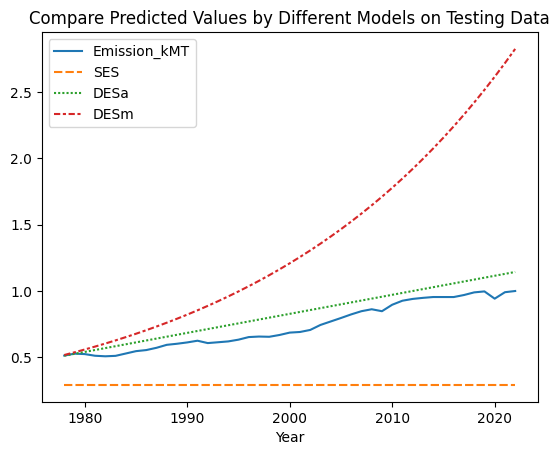

In [ ]:
sns.lineplot(testing_data[['Emission_kMT', 'SES', 'DESa', 'DESm']])
plt.title('Compare Predicted Values by Different Models on Testing Data')
plt.show()

## <font color='#e74c3c'> Remodeling for the Entire Dataset using Additive DES </font>

In [ ]:
des_model_a_2 = ExponentialSmoothing(df['Emission_kMT'], trend='add')
des_fitted_model_a_2 = des_model_a_2.fit()
df['DESa'] = des_fitted_model_a_2.fittedvalues.shift(-1)
df.head()

,Emission_kMT,DESa
Year,,
1800,8.781589e-05,9.545767e-05
1801,6.593358e-05,7.165966e-05
1802,2.901821e-04,3.101210e-04
1803,1.000000e-10,6.516793e-07
1804,6.009132e-05,6.309844e-05


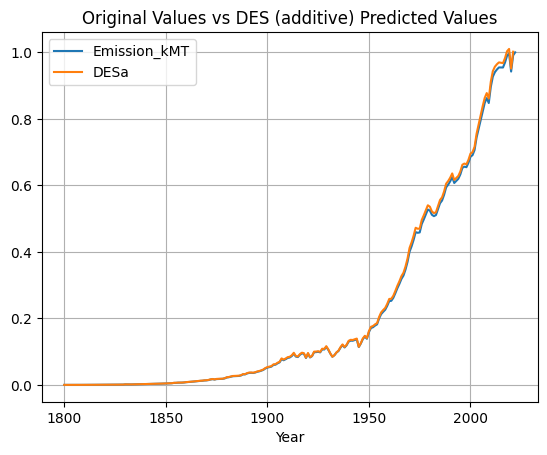

In [ ]:
df[['Emission_kMT', 'DESa']].plot()
plt.title('Original Values vs DES (additive) Predicted Values')
plt.grid()
plt.show()

### <font color='#e74c3c'> Forecasting with DES (additive) Exponential Smoothing </font>

In [ ]:
n_forecast_periods = len(testing_data.Emission_kMT)
forecasted_values = des_fitted_model_a_2.forecast(n_forecast_periods)
forecasted_values

223    1.011127
224    1.022244
225    1.033361
226    1.044478
227    1.055595
228    1.066712
229    1.077829
230    1.088946
231    1.100064
232    1.111181
233    1.122298
234    1.133415
235    1.144532
236    1.155649
237    1.166766
238    1.177883
239    1.189000
240    1.200117
241    1.211234
242    1.222351
243    1.233468
244    1.244585
245    1.255702
246    1.266819
247    1.277936
248    1.289053
249    1.300170
250    1.311287
251    1.322404
252    1.333521
253    1.344638
254    1.355755
255    1.366872
256    1.377990
257    1.389107
258    1.400224
259    1.411341
260    1.422458
261    1.433575
262    1.444692
263    1.455809
264    1.466926
265    1.478043
266    1.489160
267    1.500277
dtype: float64

<hr/>

## <font color='#e74c3c'> <u><b>2. Autoregression (AR)</b></u></font> <span style='font-size: 10pt'> (Contributed By: mohammedfayazahamed20@gmail.com) </span>

In [ ]:
model_ar = AutoReg(training_data['Emission_kMT'], lags = 6).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:           Emission_kMT   No. Observations:                  177
Model:                     AutoReg(6)   Log Likelihood                 657.695
Method:               Conditional MLE   S.D. of innovations              0.005
Date:                Tue, 07 May 2024   AIC                          -1299.389
Time:                        14:01:18   BIC                          -1274.256
Sample:                             6   HQIC                         -1289.191
                                  177                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0003      0.001     -0.648      0.517      -0.001       0.001
Emission_kMT.L1     1.0936      0.076     14.477      0.000       0.946       1.242
Emission_kMT.L2    -0.1995      

In [ ]:
start = len(training_data)
end = len(training_data)+len(testing_data)-1
pred_ar = model_ar.predict(start=start,end=end,dynamic = False)
print(pred_ar)

177    0.504765
178    0.520004
179    0.542262
180    0.568119
181    0.588908
182    0.610392
183    0.635529
184    0.660663
185    0.685249
186    0.712113
187    0.740583
188    0.769342
189    0.799205
190    0.830800
191    0.863451
192    0.897121
193    0.932310
194    0.968989
195    1.006966
196    1.046438
197    1.087566
198    1.130293
199    1.174661
200    1.220816
201    1.268814
202    1.318682
203    1.370520
204    1.424424
205    1.480454
206    1.538690
207    1.599234
208    1.662175
209    1.727599
210    1.795610
211    1.866311
212    1.939807
213    2.016207
214    2.095628
215    2.178189
216    2.264013
217    2.353230
218    2.445974
219    2.542384
220    2.642605
221    2.746789
dtype: float64


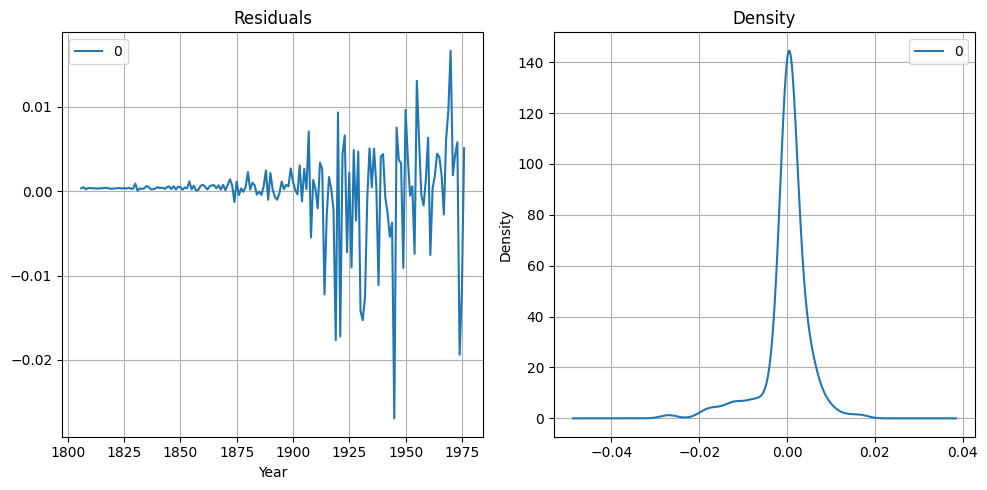

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_ar.resid)
fig, ax = plt.subplots(1,2, figsize=(10,5))
residuals.plot(title="Residuals", ax=ax[0])
ax[0].grid(True)
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(f"RMSE: {RMSE(testing_data['Emission_kMT'], pred_ar.values)}")
forecast_accuracy(pred_ar.values, testing_data['Emission_kMT'])


RMSE: 0.7669101465128182


{'mape': 0.7066830398527695,
 'me': 0.5933502321025806,
 'mae': 0.5940379124679298,
 'mpe': 0.7053597904757487,
 'mse': 0.5881511728243123}

<hr/>

## <font color='#e74c3c'> <u><b>3. ARIMA</b></u> </font>

##### <font color='#1abc9c'> Following is the scheme we will use to apply ARIMA models to the given dataset:
- First verify whether the data is stationary.
- If it is not stationary, find the order of differencing where data can become stationary. So we will find the order of Integrtion (I), <b>d</b>
- Once <b>d</b> is found, we will use Auto-regression to find the order for AR, <b>p</b>
- Then we will perform residual analysis to check whether there are any patterns remaining that are not explained by the model.
- If the patterns are found we will use moving averages on residuals to find the value of the order of MA, <b>q</b>
- We will then test the model on test data
- Finally we will create the model for the entire dataset and forecast </font>

### <font color='#1abc9c'>Verify whether data is stationary using Augmented Dickey Fuller (ADF) test.</font>

#### <font color='#1abc9c'> Function definitions </font>

In [ ]:
def adf_test_1(data_series):
    result = adfuller(data_series)
    print(f'p-value={result[1]}')
    if result[1] > 0.05:
        return 'Failed to reject null hypothesis; Time data is not stationary.'
    else:
        return 'Reject null hypothesis; Time data is stationary.'

def adf_test_2(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1] <= 0.05  # returns True if data is stationary

#### <font color='#1abc9c'> Reinstating training and testing data from the original split </font>

In [ ]:
training_data = orig_training_data.copy()
testing_data = orig_testing_data.copy()

id(orig_training_data), id(training_data), id(testing_data), id(orig_testing_data)

(133294334342192, 133294297622192, 133294297853872, 133294334344784)

In [ ]:
adf_test_1(training_data.Emission_kMT)

p-value=0.9986732283039781


'Failed to reject null hypothesis; Time data is not stationary.'

<div style="padding: 5px; background-color: #eefefe;"> <font color='#121212'> <i> <code>training_data</code> is not stationary. Therefore we will apply integration on it to find the differencing order <b>d</b> where the data becomes stationary.  </i> </font> </div>

### <font color='#1abc9c'>Find order of differencing (<b>d</b>) </font>

In [ ]:
# Iteratively difference data until it's stationary
d = 0
time_series_data = training_data.Emission_kMT.copy()
while not adf_test_2(time_series_data):
    # print(f'd={d}')
    d += 1
    time_series_data = time_series_data.diff().dropna()

print(f"The order of differencing is {d}")

The order of differencing is 2


### <font color='#1abc9c'> Auto-regression to find the order for AR, <b>p</b> </font>

<div style="padding: 5px; background-color: #eefefe;"> <font color='#121212'> <i> As is seen in the <a href="#pacf_plot">#PACF_Plot [link]</a> the order for Auto-regression, <b>p</b> is 2. We will verify this by iteratively creating AR models (<u>keeping d=2</u>) and checking for performance improvement. We will use the <u><b>Log Likelihood Ratio</b></u> (LLR) test for checking the performance. </i> </font> </div>

#### <font color='#1abc9c'> LLR Function definition </font>

- LLR = Likelihood Ratio Test
- m1 and m2 are the two models being compared.
- L1 and L2 are the log-likelihoods of these models. The log-likelihood is a measure of how well the model fits the data.
- LR is the likelihood ratio, which is based on the differences in the log-likelihoods of the two models. If LR is large, it indicates that m2 fits the data significantly better than m1.
- DF is the degrees of freedom, typically set to the difference in the number of parameters estimated by the two models.
- p is the p-value of the test. If p is small (typically ≤ 0.05), you would reject the null hypothesis that m1 fits the data as well as m2, in favor of the alternative hypothesis that m2 fits the data better.
- This function returns the p-value, which you can use to determine whether the improvement in fit from m1 to m2 is statistically significant. If the p-value is less than your chosen significance level (often 0.05), then the improvement in fit is considered statistically significant.

In [ ]:
def LLR_test(m1, m2, DF=1):
    L1 = m1.fit().llf
    L2 = m2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

#### <font color='#1abc9c'> Iteratively find the order of AR, <b>p</b></font>

In [ ]:
model_ar1 = ARIMA(training_data.Emission_kMT, order=(1,2,0))
results_ar1 = model_ar1.fit()
print(results_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:           Emission_kMT   No. Observations:                  178
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 634.743
Date:                Tue, 07 May 2024   AIC                          -1265.486
Time:                        14:01:19   BIC                          -1259.145
Sample:                             0   HQIC                         -1262.914
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4238      0.039    -10.800      0.000      -0.501      -0.347
sigma2      4.306e-05   2.57e-06     16.749      0.000     3.8e-05    4.81e-05
Ljung-Box (L1) (Q):                   5.85   Jarque-

In [ ]:
model_ar2 = ARIMA(training_data.Emission_kMT, order=(2,2,0))
results_ar2 = model_ar2.fit()
print(results_ar2.summary())

                               SARIMAX Results                                
Dep. Variable:           Emission_kMT   No. Observations:                  178
Model:                 ARIMA(2, 2, 0)   Log Likelihood                 653.407
Date:                Tue, 07 May 2024   AIC                          -1300.813
Time:                        14:01:19   BIC                          -1291.302
Sample:                             0   HQIC                         -1296.955
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6025      0.040    -14.971      0.000      -0.681      -0.524
ar.L2         -0.4543      0.046     -9.838      0.000      -0.545      -0.364
sigma2      3.476e-05   2.28e-06     15.261      0.0

In [ ]:
# Finding where the performace of model_ar2 has improved over model_ar1 using LLR test

LLR_test(model_ar1, model_ar2)

0.0

<div style="padding: 5px; background-color: #eefefe;"> <font color='#121212'> <i> As per the LLR result there is significant  performance improvement between AR models with p=1 and p=2. We will continue with (AR) modeling and evaluating to get enough data to select a range of p values. </i> </font> </div>

In [ ]:
model_ar3 = ARIMA(training_data.Emission_kMT, order=(3,2,0))
results_ar3 = model_ar3.fit()
print(results_ar3.summary())
LLR_test(model_ar2, model_ar3)

                               SARIMAX Results                                
Dep. Variable:           Emission_kMT   No. Observations:                  178
Model:                 ARIMA(3, 2, 0)   Log Likelihood                 663.438
Date:                Tue, 07 May 2024   AIC                          -1318.875
Time:                        14:01:19   BIC                          -1306.193
Sample:                             0   HQIC                         -1313.731
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7493      0.039    -19.234      0.000      -0.826      -0.673
ar.L2         -0.6649      0.054    -12.214      0.000      -0.772      -0.558
ar.L3         -0.3471      0.057     -6.060      0.0

0.0

In [ ]:
model_ar4 = ARIMA(training_data.Emission_kMT, order=(4,2,0))
results_ar4 = model_ar4.fit()
print(results_ar4.summary())
LLR_test(model_ar3, model_ar4)

                               SARIMAX Results                                
Dep. Variable:           Emission_kMT   No. Observations:                  178
Model:                 ARIMA(4, 2, 0)   Log Likelihood                 663.535
Date:                Tue, 07 May 2024   AIC                          -1317.069
Time:                        14:01:20   BIC                          -1301.217
Sample:                             0   HQIC                         -1310.640
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7601      0.041    -18.440      0.000      -0.841      -0.679
ar.L2         -0.6847      0.060    -11.475      0.000      -0.802      -0.568
ar.L3         -0.3725      0.065     -5.744      0.0

0.659

<div style="padding: 5px; background-color: #eefefe;"> <font color='#121212'> <i> As per the LLR result, here, there is no significant  performance improvement between AR models with p=3 and p=4. We can select value of <b>p=3</b>. </i> </font> </div>

### <font color='#1abc9c'> Residual Analysis (to find <b>q</b>) </font>

<div style="padding: 5px; background-color: #eefefe;"> <font color='#121212'> <i> If we observe any pattern in the residuals for the selected AR model ('model_ar3'), it will indicate that the model has not captured the time series pattern completely. We check for any patterns in the residuals as follow ...  </i> </font> </div>

#### <font color='#1abc9c'> Check for the following assumptions </font>

- Mean = 0
- Constant variance
- Normally distributed
- No auto-correlation </font>

##### <font color='#1abc9c'> Checking for <u> Mean = 0 </u> in the residuals in model model_ar3 </font>

In [ ]:
training_data['ar3_residuals'] = results_ar3.resid
training_data.ar3_residuals.mean()

0.0001837508028493817

##### <font color='#1abc9c'> Checking for <u>Constant Variance</u> in the residuals in model model_ar3 </font>

In [ ]:
adf_test_1(training_data['ar3_residuals'])

p-value=6.005742463524072e-05


'Reject null hypothesis; Time data is stationary.'

##### <font color='#1abc9c'> Checking for <u>Normal Distribution</u> of the residuals in model model_ar3 </font>

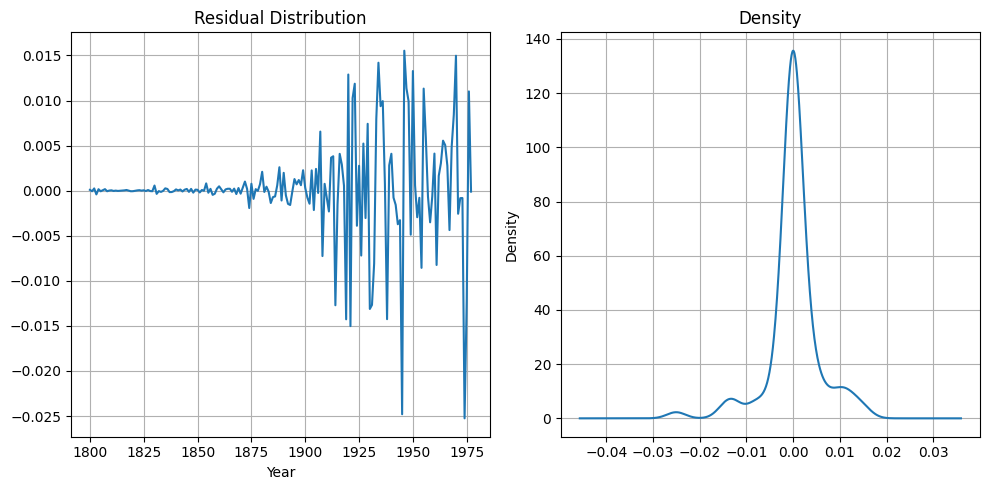

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
training_data['ar3_residuals'].plot(title='Residual Distribution', ax=ax[0])
training_data['ar3_residuals'].plot(kind='kde', title='Density', ax=ax[1])
ax[0].grid(True)
ax[1].grid(True)
plt.tight_layout()
plt.show()

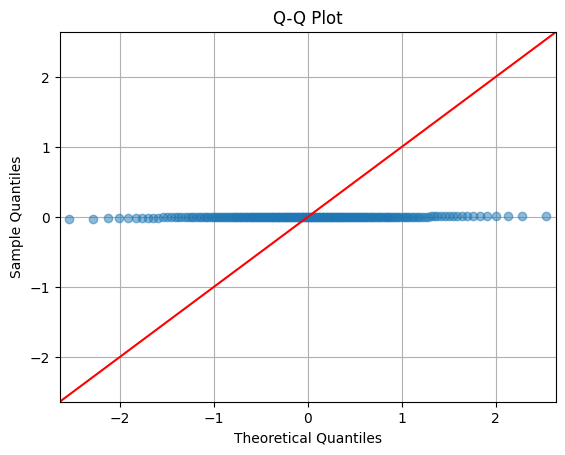

In [ ]:
pp = ProbPlot(training_data['ar3_residuals'])
pp.qqplot(line='45', alpha=0.5, lw=1)
plt.title('Q-Q Plot')
plt.grid()
plt.show()

<div style="padding: 5px; background-color: #eefefe;"> <font color='#121212'> <i> The third criterion (Normal Distribution of residuals) for checking whether there is a pattern left uncaptured by the AR model, is not satisfied. Therefore, we will now iteratively apply MA on the residuals and find the value of </i> <b>q</b> </font> </div>

### <font color='#1abc9c'> Adding Moving Averate (MA) component to the model iteratively. (Determining <b>q</b>) </font>

In [ ]:
model_ma1 = ARIMA(training_data.Emission_kMT, order=(3,2,1))
results_ma1 = model_ma1.fit()
print(results_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:           Emission_kMT   No. Observations:                  178
Model:                 ARIMA(3, 2, 1)   Log Likelihood                 665.962
Date:                Tue, 07 May 2024   AIC                          -1321.924
Time:                        14:01:22   BIC                          -1306.072
Sample:                             0   HQIC                         -1315.495
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2951      0.100     -2.960      0.003      -0.491      -0.100
ar.L2         -0.3726      0.091     -4.115      0.000      -0.550      -0.195
ar.L3         -0.1219      0.083     -1.469      0.1

In [ ]:
model_ma2 = ARIMA(training_data.Emission_kMT, order=(3,2,2))
results_ma2 = model_ma2.fit()
print(results_ma2.summary())

                               SARIMAX Results                                
Dep. Variable:           Emission_kMT   No. Observations:                  178
Model:                 ARIMA(3, 2, 2)   Log Likelihood                 669.138
Date:                Tue, 07 May 2024   AIC                          -1326.275
Time:                        14:01:23   BIC                          -1307.252
Sample:                             0   HQIC                         -1318.559
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5147      0.811     -0.635      0.526      -2.105       1.075
ar.L2         -0.2733      0.101     -2.699      0.007      -0.472      -0.075
ar.L3         -0.1436      0.189     -0.758      0.4

In [ ]:
# Finding where the performace of model_ma2 has improved over model_ma1 using LLR test

LLR_test(model_ma1, model_ma2)

0.012

<div style="padding: 5px; background-color: #eefefe;"> <font color='#121212'> <i> p-value is more than significance level ∝=0.05; this means that there is no performance improvement between models with q=1 and q=2. However, as per the <a href='#acf_plot'> #ACF_Plot [link] </a> the possible auto correlation factors are high for a lag up to around 18 periods. Therefore we will continue with the process of developing models and LLR_testing the performance improvement. </i></font></div>

In [ ]:
prev_model = model_ma2
for i in range(3, 19):
    model_ma_current = ARIMA(training_data.Emission_kMT, order=(3,2,i))
    results_ma_current = model_ma_current.fit()
    # print(results_ma2.summary())
    print(f'(3,2,{i}): {LLR_test(prev_model, model_ma_current)}')
    prev_model = model_ma_current

(3,2,3): 0.0
(3,2,4): 0.042
(3,2,5): 1.0
(3,2,6): 1.0
(3,2,7): 0.001
(3,2,8): 1.0
(3,2,9): 0.008
(3,2,10): 1.0
(3,2,11): 0.0
(3,2,12): 1.0
(3,2,13): 0.0
(3,2,14): 1.0
(3,2,15): 0.018
(3,2,16): 1.0
(3,2,17): 0.127
(3,2,18): 0.153


<div style="padding: 5px; background-color: #eefefe;"> <font color='#121212'> <i> Based on the above calculations there are several combinations of <b>p</b>,<b>d</b>,<b>q</b> values that we can develop models for to give the most optimum fit. We will instead select the values for <b>p</b>,<b>d</b>,<b>q</b> values by evaluating the RMSE metric as we apply the models to the test data iteratively, and then select the model with the least RMSE value. </i></font></div>

## <font color='#e74c3c'> Testing ARIMA </font>

In [ ]:
testing_data.isna().sum()

Emission_kMT    0
dtype: int64

#### <font color='#1abc9c'> Iterate over a range of values for <b>p</b>,<b>d</b>,<b>q</b> to create models and testing on <code>testing_data</code>. Calculate and record RMSE for each iteration. </font>

In [ ]:
key = ''
rmse_val = 0
rmse_metrics = {}
prev_model = ARIMA(training_data.Emission_kMT, order=(1,1,1))
for p in range(2,5):
    for d in range(2,4):
        for q in range(2, 10):
            print(f'Modeling ARIMA for ({p},{d},{q}) ...', end=' ')
            model_current = ARIMA(training_data.Emission_kMT, order=(p,d,q))
            results_current = model_current.fit()
            print('Done.', end='; ')
            # print(results_ma2.summary())
            print(f'Testing ARIMA for ({p},{d},{q}) ...', end=' ')
            forecast_values = results_current.forecast(len(testing_data['Emission_kMT']))
            forecast_values.index = testing_data.index
            testing_data['forecasted_values'] = forecast_values
            print('Done.')
            rmse_val = RMSE(testing_data.Emission_kMT, testing_data.forecasted_values)
            key = f'({p},{d},{q})'
            print(f'{key}: {rmse_val}')
            rmse_metrics[key] = rmse_val
            prev_model = model_ma_current

Modeling ARIMA for (2,2,2) ... Done.; Testing ARIMA for (2,2,2) ... Done.
(2,2,2): 0.08380863465931726
Modeling ARIMA for (2,2,3) ... Done.; Testing ARIMA for (2,2,3) ... Done.
(2,2,3): 0.08265845072840049
Modeling ARIMA for (2,2,4) ... Done.; Testing ARIMA for (2,2,4) ... Done.
(2,2,4): 0.08581352415611283
Modeling ARIMA for (2,2,5) ... Done.; Testing ARIMA for (2,2,5) ... Done.
(2,2,5): 0.08331116030907952
Modeling ARIMA for (2,2,6) ... Done.; Testing ARIMA for (2,2,6) ... Done.
(2,2,6): 0.08383323528311383
Modeling ARIMA for (2,2,7) ... Done.; Testing ARIMA for (2,2,7) ... Done.
(2,2,7): 0.13019400525817929
Modeling ARIMA for (2,2,8) ... Done.; Testing ARIMA for (2,2,8) ... Done.
(2,2,8): 0.1568940884846002
Modeling ARIMA for (2,2,9) ... Done.; Testing ARIMA for (2,2,9) ... Done.
(2,2,9): 0.16398523639565749
Modeling ARIMA for (2,3,2) ... Done.; Testing ARIMA for (2,3,2) ... Done.
(2,3,2): 0.266534347963907
Modeling ARIMA for (2,3,3) ... Done.; Testing ARIMA for (2,3,3) ... Done.
(2

#### <font color='#1abc9c'> Find the optimum <b>p</b>,<b>d</b>,<b>q</b> values </font>

In [ ]:
rmse_vals = list(rmse_metrics.values())
min_rmse_val = min(rmse_vals)
optimum_params = list(rmse_metrics.keys())[rmse_vals.index(min_rmse_val)]
optimum_params

'(2,3,5)'

## <font color='#1abc9c'> Create and apply the final model and plot the values</font>

In [ ]:
final_model = ARIMA(training_data.Emission_kMT, order=(2,3,5))
final_results = final_model.fit()
forecast_values = final_results.forecast(len(testing_data['Emission_kMT']))
forecast_values.index = testing_data.index
testing_data['forecasted_values'] = forecast_values
testing_data

,Emission_kMT,forecasted_values
Year,,
1978,0.512851,0.501389
1979,0.527391,0.505647
1980,0.524132,0.525297
1981,0.511588,0.531048
1982,0.507500,0.538064
1983,0.510753,0.552822
1984,0.528419,0.561067
1985,0.546275,0.569662
1986,0.554395,0.582153


In [ ]:
print(f"RMSE: {RMSE(testing_data['forecasted_values'], testing_data['Emission_kMT'])}")
forecast_accuracy(testing_data['Emission_kMT'], testing_data['forecasted_values'])

RMSE: 0.037762287705776644


{'mape': 0.0446645204871817,
 'me': -0.0014559533137157078,
 'mae': 0.03302771335716022,
 'mpe': -0.007513430837453704,
 'mse': 0.0014259903727738498}

## <font color='#e74c3c'> Remodeling for the Entire Dataset using (<b>p</b>,<b>d</b>,<b>q</b>) values as (2,3,5) </font>

In [ ]:
df.isna().sum(), df.isnull().sum()

(Emission_kMT    0
 DESa            1
 dtype: int64,
 Emission_kMT    0
 DESa            1
 dtype: int64)

In [ ]:
model_final = ARIMA(df.Emission_kMT, order=(2,3,5))
results_final = model_final.fit()
print(results_final.summary())
forecast_values = results_final.forecast(len(df['Emission_kMT']))
forecast_values.index = df.index
df['ARIMA'] = results_final.fittedvalues
print(f'RMSE={RMSE(df.Emission_kMT, df.ARIMA)}')

                               SARIMAX Results                                
Dep. Variable:           Emission_kMT   No. Observations:                  223
Model:                 ARIMA(2, 3, 5)   Log Likelihood                 710.380
Date:                Tue, 07 May 2024   AIC                          -1404.759
Time:                        14:03:58   BIC                          -1377.610
Sample:                             0   HQIC                         -1393.796
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4570      0.078    -18.687      0.000      -1.610      -1.304
ar.L2         -0.7833      0.081     -9.621      0.000      -0.943      -0.624
ma.L1         -0.3642      0.086     -4.235      0.0

In [ ]:
df.head()

,Emission_kMT,DESa,ARIMA
Year,,,
1800,8.781589e-05,9.545767e-05,0.000000
1801,6.593358e-05,7.165966e-05,0.000176
1802,2.901821e-04,3.101210e-04,0.000018
1803,1.000000e-10,6.516793e-07,0.000761
1804,6.009132e-05,6.309844e-05,-0.000314


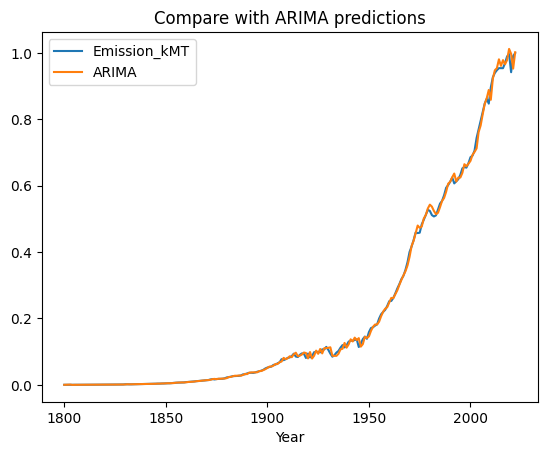

In [ ]:
df[['Emission_kMT', 'ARIMA']].plot()
plt.title('Compare with ARIMA predictions')
plt.show()

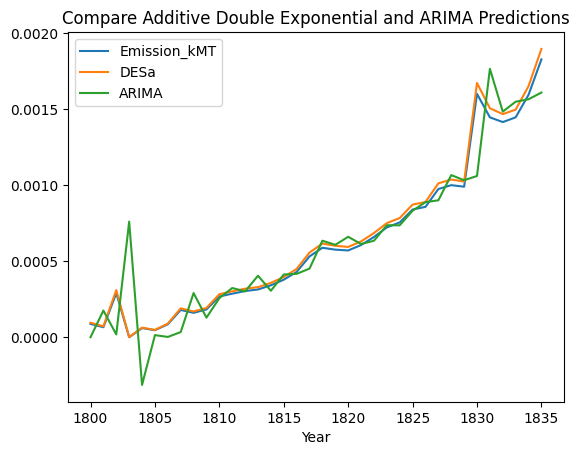

In [ ]:
df[['Emission_kMT', 'DESa', 'ARIMA']].iloc[:36].plot()
plt.title('Compare Additive Double Exponential and ARIMA Predictions')
plt.show()

### <font color='#e74c3c'> Forecasting with ARIMA</font>

<div style="padding: 5px; background-color: #eefefe;"> <font color='#121212'> <i> We forecast for as many periods as we have tested for. </i></font></div>

In [ ]:
results_final.forecast(len(testing_data['Emission_kMT']))

223    1.001876
224    1.010801
225    1.021280
226    1.022983
227    1.035591
228    1.038521
229    1.046346
230    1.053956
231    1.057381
232    1.066407
233    1.069887
234    1.076397
235    1.082172
236    1.085980
237    1.092566
238    1.095982
239    1.101177
240    1.105599
241    1.109089
242    1.113878
243    1.116841
244    1.120783
245    1.124065
246    1.126878
247    1.130227
248    1.132498
249    1.135256
250    1.137485
251    1.139439
252    1.141544
253    1.142981
254    1.144609
255    1.145818
256    1.146824
257    1.147790
258    1.148309
259    1.148846
260    1.149043
261    1.149058
262    1.148941
263    1.148494
264    1.147967
265    1.147152
266    1.146155
267    1.144984
Name: predicted_mean, dtype: float64

In [ ]:
df = df.drop(columns=['DESa', 'ARIMA'])

In [ ]:
# Define the forecast period
forecast_years = 5
start_year = df.index.max() + 1
end_year = start_year + forecast_years - 1

# Forecast using the Double Exponential Smoothing model
forecast = des_fitted_model_a_2.forecast(steps=forecast_years)

# Create a DataFrame for the forecasted years
forecast_df = pd.DataFrame({
    'Year': range(start_year, end_year + 1),
    'Emission_kMT': forecast
})

In [ ]:
forecast_df

,Year,Emission_kMT
223,2023,1.011127
224,2024,1.022244
225,2025,1.033361
226,2026,1.044478
227,2027,1.055595


In [ ]:
forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 223 to 227
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          5 non-null      int64  
 1   Emission_kMT  5 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 212.0 bytes


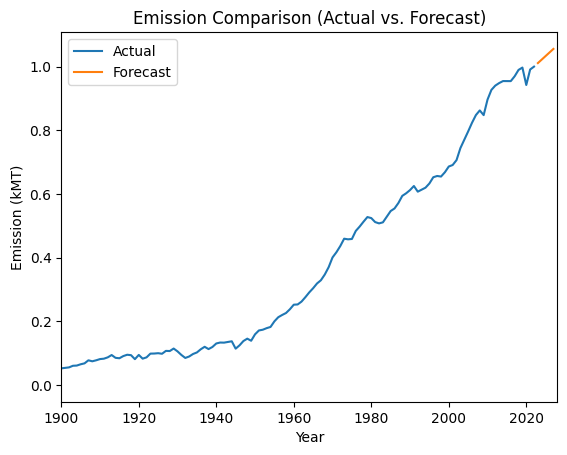

In [ ]:
# Plot the data using the same x-axis for both DataFrames
plt.plot(df.index, df['Emission_kMT'], label='Actual')
plt.plot(forecast_df.Year, forecast_df['Emission_kMT'], label='Forecast')

# Add labels and title
plt.xlim(1900, 2028)
plt.xlabel('Year')
plt.ylabel('Emission (kMT)')
plt.title('Emission Comparison (Actual vs. Forecast)')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
forecast_df.to_csv('forecasted_data_5_years.csv', index=False)

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


In [ ]:
import pickle

In [ ]:
#pickle.dump(results_final, open('Forecast_arima.pkl','wb'))

In [ ]:
! wget -q -O - ipv4.icanhazip.com

34.125.80.236


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501





  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.80.236:8501

npx: installed 22 in 5.612s
your url is: https://nice-mammals-hammer.loca.lt
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmode

<pre>                                     - - - - - End of Program - - - - - </pre>